# Emergence, pretraining loss and associative recall: a toy model

# Before you run any cells:

## [Get pretrained checkpoints from shared Google Drive](https://drive.google.com/drive/folders/1KALcTkduq9uFj7CJ6CaGBvAgsJuXGn58?usp=drive_link)

Go to the link in the title of this cell for zip files of the model checkpoints. Right click on the `ortho_haar_ckpts` in Google Drive, and then click `Organize`, then `Add Shortcut`. In the `All locations` tab, choose `MyDrive` as the place to put the shortcut.

This must be done since we are unsure how to get Google Colab to pull from a Google Drive that is not the user's. We couldn't add the checkpoints to the anonymous Github repo since they are ~8 GB.

This takes ~2:30 min.

In [ ]:
import zipfile

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
model_sizes = ["tiny", "small", "medium", "big"]
experiment_names = ["250508_234147.a7058e_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_0.00012679145539688913_num_train_sys_40000",
                    "250507_024037.72e4da_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.4827548953825996e-05_num_train_sys_40000",
                    "250418_125901.8d6b22_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000",
                    "250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000"]

model_count = 0

for model_size in model_sizes:

  experiment_name = experiment_names[model_count]

  zip_file_path = f"/content/drive/MyDrive/ortho_haar_ckpts/ortho_haar_{model_size}_ckpts/pruned.zip"  # Path to your zip file
  extract_path = f"/data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/{experiment_name}/checkpoints" # Path to destination folder

  import os
  os.makedirs(extract_path, exist_ok=True)

  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)

  cd_path =  f"/data/shared/ICL_Kalman_Experiments/model_checkpoints/GPT2/{experiment_name}/checkpoints/pruned"
  os.system(f"cd {cd_path} && mv * ..")
  model_count += 1

## We recommend using the T4 runtime

You can hit run all from here! It will take around (insert time)

#### Clone the Github repo

In [ ]:
!git clone https://github.com/anon4mossreview/moss_2025.git

Install packages

In [ ]:
!pip install filterpy numpy scipy control pytorch_lightning tensordict coloredlogs dimarray

## Generate Test Data

In [ ]:
%cd moss_2025/src

Generate test data to be interleaved for needle-in-haystack tests.

---

Takes ~30 sec to run.

In [ ]:
!python collect_data.py --val

Generate test data to be interleaved for pretraining-style tests.

---

Takes ~30 sec to run.

In [ ]:
!python collect_data.py --val --multi_cut_val

# Emergence of recall

In the plots below, notice that the model's prediction on the first index after the final query open symbol has poor performance for most of training, until suddenly it learns to recall the previously seen segment. Interestingly, the model's ability to predict the second, third, seventh, and more indices after the final query open symbol emerges earlier in training.

In these plots, the model is tested on structured needle-in-a-haystack examples where every segment is 10 entries long (excluding punctuating symbols) and there are 5 segments in the haystack.



#### Medium model (~9.1M parameters)



---


This takes ~1 min to run on the T4 runtime.


In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_medium_single_gpu

#### Big Model (~20.7M parameters)

Notice that with a larger model, the phase transitions appear to occur earlier in training. Also, notice that the big model exhibits overfitting in the initial segment very late in training.

---



This takes ~3 min to run on the T4 runtime.

In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_big

#### Small Model (~5.7M parameters)

With a smaller model, the phase transitions occur later.

---


This takes ~1 min to run on the T4 runtime.

In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_small

#### Tiny Model (~4M parameters)

With an even smaller model, the phase transition might not even occur.


---


This takes less then 1 min to run on the T4 runtime.

In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_tiny

## Emergence of restarting a new system


In the below plots, we look at the performance of the model on the 6th segment, which comes from a system that has not been seen before in-context. For 1 and 2 steps in the optimal prediction is zero. For steps 7,8 and beyond, perfection prediction accuracy is possible in-principle. And for the indices in-between, the optimal mean-squared error decreases successively with each step. The model's performance plateaus on these initial segments early in training, but quickly improves much earlier than the improvement seen in recall task from the previous section.

#### Medium model (~9.1M parameters)



---


This takes ~1 min to run on the T4 runtime.


In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_medium_single_gpu --irrelevant_tokens --new_hay_insert --all_steps_in

This plot focuses on just the indices after the final query open symbol.

In [ ]:
%run init_seg_restart_train_conv.py --model_name ortho_haar_medium_single_gpu

#### Big model (~20.7M parameters)



---


This takes ~3 min to run on the T4 runtime.


In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_big --irrelevant_tokens --new_hay_insert --all_steps_in

In [ ]:
%run init_seg_restart_train_conv.py --model_name ortho_haar_big

#### Small model (~5.7M parameters)



---


This takes ~1 min to run on the T4 runtime.


In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_small --irrelevant_tokens --new_hay_insert --all_steps_in

In [ ]:
%run init_seg_restart_train_conv.py --model_name ortho_haar_small

#### Tiny model (~4M parameters)



---


This takes less than 1 min to run on the T4 runtime.


In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_tiny --irrelevant_tokens --new_hay_insert --all_steps_in

In [ ]:
%run init_seg_restart_train_conv.py --model_name ortho_haar_tiny

## Compute pretraining error

Instead of testing on structured needle-in-a-haystack test examples, we now test each model on held-out data that is interleaved in the same randomized way as the training data.

#### Tiny Model-4M

---

Takes ~ 1 min on the T4 runtime.

In [ ]:
%run data_train.py --train_conv --make_preds --model_name ortho_haar_tiny --multi_cut_val

#### Small Model-5.7M


---

Takes ~ 2M on the T4 runtime.

In [ ]:
%run data_train.py --train_conv --make_preds --model_name ortho_haar_small --multi_cut_val

#### Medium model


---
Takes 4 min to run.


In [ ]:
%run data_train.py --train_conv --make_preds --model_name ortho_haar_medium_single_gpu --multi_cut_val

#### Big Model



In [ ]:
%run data_train.py --train_conv --make_preds --model_name ortho_haar_big --multi_cut_val

## Pretraining loss dynamics

Below is a plot of the held-out pretraining error of each model as training continues. The pseudoinverse predictor is the fundamental baseline computed by $\hat{\mathbf{x}}_{i+1} = \hat{U}\mathbf{x}_i$, where
\begin{align}
    \hat{U} = \begin{bmatrix}\mathbf{x}_1 & \dots & \mathbf{x}_i \end{bmatrix}\begin{bmatrix}\mathbf{x}_0 & \dots & \mathbf{x}_{i-1} \end{bmatrix}^{\dagger},
\end{align}
and $X^{\dagger}$ denotes the Moore-Penrose pseudoinverse of $X$.

Notice that larger models decrease their pretraining error faster than smaller models do, at the cost of overfitting earlier in training, as you see their performance deteriorate late in training.

In [ ]:
%run pretrain_loss.py

### When do abilities emerge with respect to the pretraining loss?


---

Instead of plotting the MSE of the model's predictions vs the number of training examples, we now plot MSE of the model's predictions vs the pretrainining error of the model at that checkpoint. We see that the abilities of each model size emerge very closely around different pretraining loss values.

In [ ]:
%run pretrain_x_axis.py

# Interpretability

**Misdirecting with a previous symbolic label displays the model's Bayesian tendencies even with label interference.**
We finally attempt to misdirect the model towards treating a brand new sequence as an old one by providing a symbolic label it has seen in its context. See the diagram below.
We find that when controlling for the position in the haystack (sequences introduced later in context perform worse early in training) *the 2+ after final tasks perform equivalently*:  when given the correct new symbolic label, and when shown a symbolic label misdirecting to a sequence that has already been observed in context.
This supports the idea that the model is label-ignoring Bayesian. It recognizes that the sequence it is seeing does not correspond to a sequence it has already seen.
However, the point in training where we see the model start leveraging the label in the unseen symbolic label experiment is approximately when performance for 2 after final in this setup starts to degrade, suggesting the model may be starting to try to leverage the symbolic label.

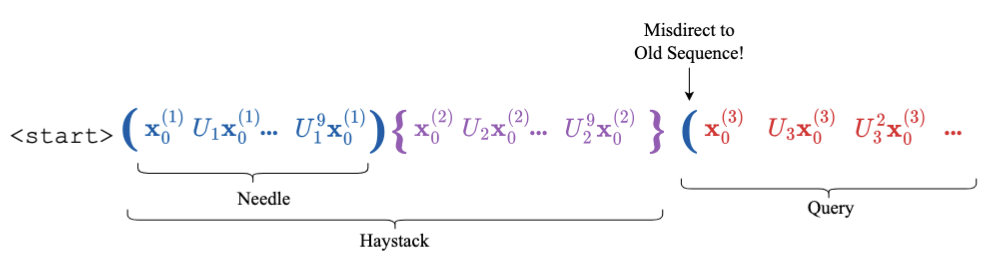

In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_medium_single_gpu --new_hay_insert

**Misdirecting the model towards the incorrect sequence in the haystack falsifies pure label-based recall and provides strong evidence for observation-based Bayesian recall.**  

---



In order to test the label-based recall hypothesis, we provide the model with the incorrect symbolic label as depicted in the diagram below. The goal of this experiment was to test if the model would apply the recalled system to the observed payload or leverage the observation to perform Bayesian prediction. Our results show that the model ignores the misdirection and leverages the observation to perform prediction. The baseline performance without misdirection for the 2+ after tasks shown in the below plots matches exactly what we see with misdirection in the earlier plots that showed the emergence of recall. This is strong evidence that the model applies a Bayesian approach for the 2+ after tasks when being shown a symbolic label it has seen in context.

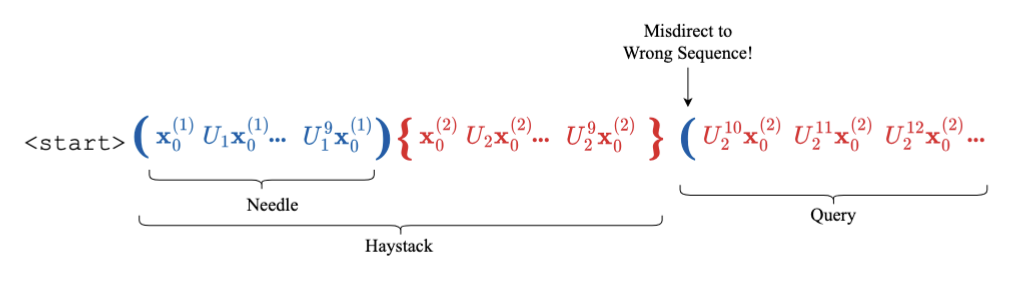

In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_medium_single_gpu --paren_swap

**Synchronizing previous systems in the haystack to necessitate symbol-based disambiguation displays that the model does not exclusively leverage a Bayesian approach.**


---


We construct an experiment where two different systems have equivalent payloads on the one-after observation, effectively making the 2 after task ambiguous if the models leverage Bayes. To do this we generate a single payload at $\mathbf{x}_{10} \sim \mathcal{N}\left(0,\frac{1}{5}I\right)$ for all systems and generate the haystack by "rewinding" our systems back to $\mathbf{x}_0$ by $\mathbf{x}_{i-1} = U^T\mathbf{x}_i$ as is shown in Figure \ref{fig:ortho_sync_diagram}. In this case given the ambiguity of which system $\mathbf{x}_{10}$ (the 1-after observation) corresponds to, the model must leverage the symbolic label to disambiguate the sequence. We find that not only does the model fail to do the 2-after task, *but in fact the model continues to struggle even through 8-after* where it under performs the 8 after initial baseline as shown in the plots below. This indicates that the model is not strictly performing Bayesian prediction either, as after seeing multiple examples following the symbolic label, it should be able to disambiguate between the systems.

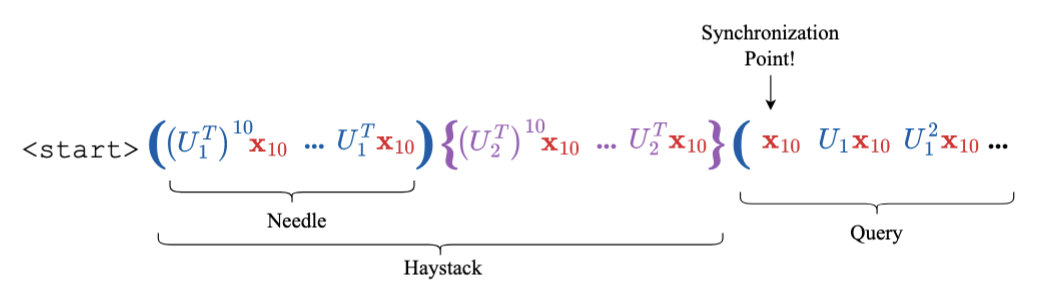

In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_medium_single_gpu --ortho_sync

**Misdirecting with an unseen symbolic label highlights a phase transition in model behavior: mediating between observation-based disambiguation and label-based disambiguation.**


---


We attempt to misdirect the model towards applying a new symbolic label to the continuation of a sequence it has already seen. See the diagram below. Through the initial stages of training, the model ignores the symbolic label and continues the sequence it has already seen as shown in the plots below. After associative recall emerges later in training, and the model learns how to leverage the labels, it moves towards treating a continuation of the old sequence as a brand new sequence corresponding to the new label. This suggests that the model performs unmediated observation-based Bayesian recall through the initial part of training, but after emergence, leverages the unseen label to treat the new observations as a new sequence.

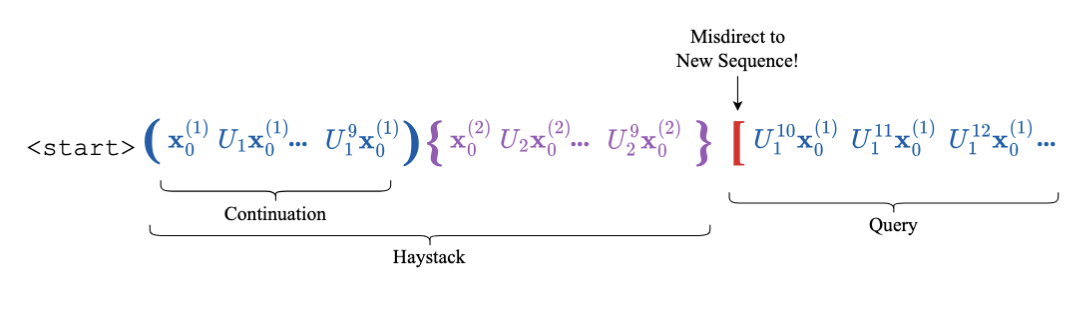

In [ ]:
%run data_train.py --multi_haystack --make_preds --model_name ortho_haar_medium_single_gpu --irrelevant_tokens